# Collaborative Filtering

In [1]:
import logging

from pprint import pprint

import matplotlib.pyplot as plt

# from fastai.basics import *
# from fastai.callback.all import *
# from fastai.torch_basics import *
# from fastai.data.all import *

from fastai.tabular.all import *
from fastai.collab import *

from fastai.collab import (EmbeddingDotBias, Learner, MSELossFlat, EarlyStoppingCallback, default_device)

import vaep
import vaep.model
import vaep.models as models
from vaep.models import plot_loss, RecorderDump

import vaep.nb
from vaep import sampling
from vaep.io import datasplits

from vaep.logging import setup_logger

# overwriting Recorder callback with custom plot_loss
from fastai import learner
learner.Recorder.plot_loss = plot_loss
# import fastai.callback.hook # Learner.summary


logger = setup_logger(logger=logging.getLogger('vaep'))
logger.info(
    "Experiment 03 - Analysis of latent spaces and performance comparisions")

figures = {}  # collection of ax or figures

vaep - INFO     Experiment 03 - Analysis of latent spaces and performance comparisions


Papermill script parameters:

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # change default to pickled files
# training
epochs_max: int = 20  # Maximum number of epochs
# early_stopping:bool = True # Wheather to use early stopping or not
patience: int = 1  # Patience for early stopping
batch_size: int = 32_768  # Batch size for training (and evaluation)
cuda: bool = True  # Use the GPU for training?
# model
# Dimensionality of encoding dimension (latent space of model)
latent_dim: int = 10
# hidden_layers:str = '128_64' # Underscore separated string of layers, '128 64' for the encoder, reversed for decoder
sample_idx_position: int = 0  # position of index which is sample ID
model: str = 'CF'  # model name
model_key: str = 'CF'  # potentially alternative key for model (grid search)
save_pred_real_na: bool = True  # Save all predictions for missing values

In [4]:
# Parameters
folder_experiment = "runs/example"
file_format = "csv"
latent_dim = 50
batch_size = 4096
epochs_max = 3
sample_idx_position = 0
cuda = False
save_pred_real_na = True
fn_rawfile_metadata = "data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv"
model_key = "CF"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/example',
 'folder_data': '',
 'file_format': 'csv',
 'epochs_max': 3,
 'patience': 1,
 'batch_size': 4096,
 'cuda': False,
 'latent_dim': 50,
 'sample_idx_position': 0,
 'model': 'CF',
 'model_key': 'CF',
 'save_pred_real_na': True,
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'}

In [6]:
args = vaep.nb.args_from_dict(args)

# # Currently not needed -> DotProduct used, not a FNN
# if isinstance(args.hidden_layers, str):
#     args.overwrite_entry("hidden_layers", [int(x) for x in args.hidden_layers.split('_')])
# else:
#     raise ValueError(f"hidden_layers is of unknown type {type(args.hidden_layers)}")
args

{'batch_size': 4096,
 'cuda': False,
 'data': Path('runs/example/data'),
 'epochs_max': 3,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/example'),
 'latent_dim': 50,
 'model': 'CF',
 'model_key': 'CF',
 'out_figures': Path('runs/example/figures'),
 'out_folder': Path('runs/example'),
 'out_metrics': Path('runs/example'),
 'out_models': Path('runs/example'),
 'out_preds': Path('runs/example/preds'),
 'patience': 1,
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

if not args.cuda:
    default_device(use=False)  # set to cpu

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/example/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/example/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/example/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X

Sample ID                                       Gene Names
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070  AAR2         27.248
                                                ABCB6        24.472
                                                ABHD11       25.714
                                                ACAD9        28.542
                                                ACTL6A       29.335
                                                              ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  WNK1         27.444
                                                YBX1         32.605
                                                YTHDF1       25.548
                                                YWHAH        30.419
                                                ZNF326       29.720
Name: intensity, Length: 15466, dtype: float64

In [10]:
# ! add check that specified data is available
# silent error in fastai if e.g. target column is not available

Infer index names from long format

In [11]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError(
        "More than one feature: Needs to be implemented. see above logging output.")

vaep - INFO     sample_id = 'Sample ID', single feature: index_column = 'Gene Names'


### Use some simulated missing for evaluation

The validation simulated NA is used to by all models to evaluate training performance.

In [12]:
val_pred_simulated_na = data.val_y.to_frame(name='observed')
val_pred_simulated_na

,,observed
Sample ID,Gene Names,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250
...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470


In [13]:
test_pred_simulated_na = data.test_y.to_frame(name='observed')
test_pred_simulated_na.describe()

,observed
count,859.000
mean,28.270
std,2.543
min,22.254
25%,26.477
50%,28.068
75%,30.064
max,35.919


## Collaborative Filtering

- save custom collab batch size (increase AE batch size by a factor), could be setup separately.
- the test data is used to evaluate the performance after training

In [14]:
# larger mini-batches speed up training
ana_collab = models.collab.CollabAnalysis(
    datasplits=data,
    sample_column=sample_id,
    item_column=index_column,  # not generic
    target_column='intensity',
    model_kwargs=dict(n_factors=args.latent_dim,
                      y_range=(int(data.train_X.min()),
                               int(data.train_X.max()) + 1)
                      ),
    batch_size=args.batch_size)

In [15]:
print("Args:")
pprint(ana_collab.model_kwargs)

Args:
{'n_factors': 50, 'y_range': (20, 37)}


In [16]:
ana_collab.model = EmbeddingDotBias.from_classes(
    classes=ana_collab.dls.classes,
    **ana_collab.model_kwargs)

args.n_params = models.calc_net_weight_count(ana_collab.model)
ana_collab.params['n_parameters'] = args.n_params
ana_collab.learn = Learner(dls=ana_collab.dls, model=ana_collab.model, loss_func=MSELossFlat(),
                           cbs=EarlyStoppingCallback(patience=args.patience),
                           model_dir=args.out_models)
if args.cuda:
    ana_collab.learn.model = ana_collab.learn.model.cuda()
else:
    # try to set explicitly cpu in case not cuda
    # MPS logic might not work properly in fastai yet https://github.com/fastai/fastai/pull/3858
    ana_collab.learn.model = ana_collab.learn.model.cpu()

# learn.summary() # see comment at DAE

### Training

suggested_lr.valley = 0.00437


epoch,train_loss,valid_loss,time
0,6.765793,6.017883,00:00
1,6.588053,5.816575,00:00
2,6.466160,5.728734,00:00


vaep.plotting - INFO     Saved Figures to runs/example/figures/collab_training


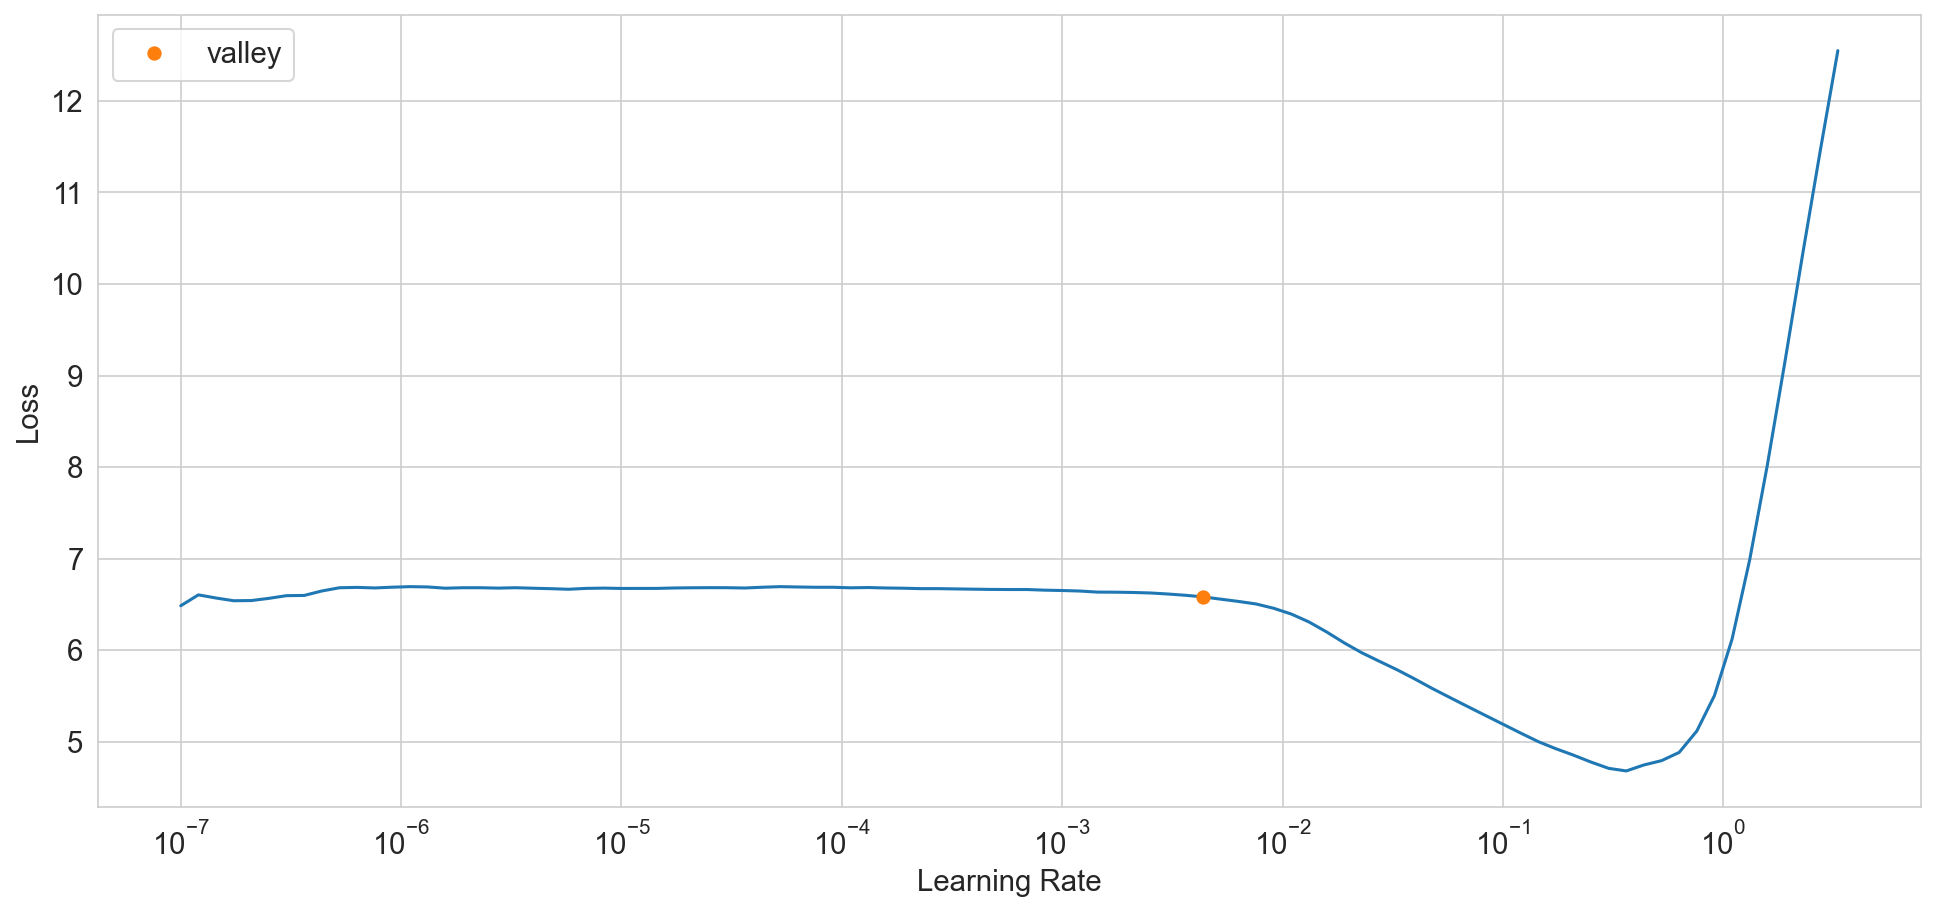

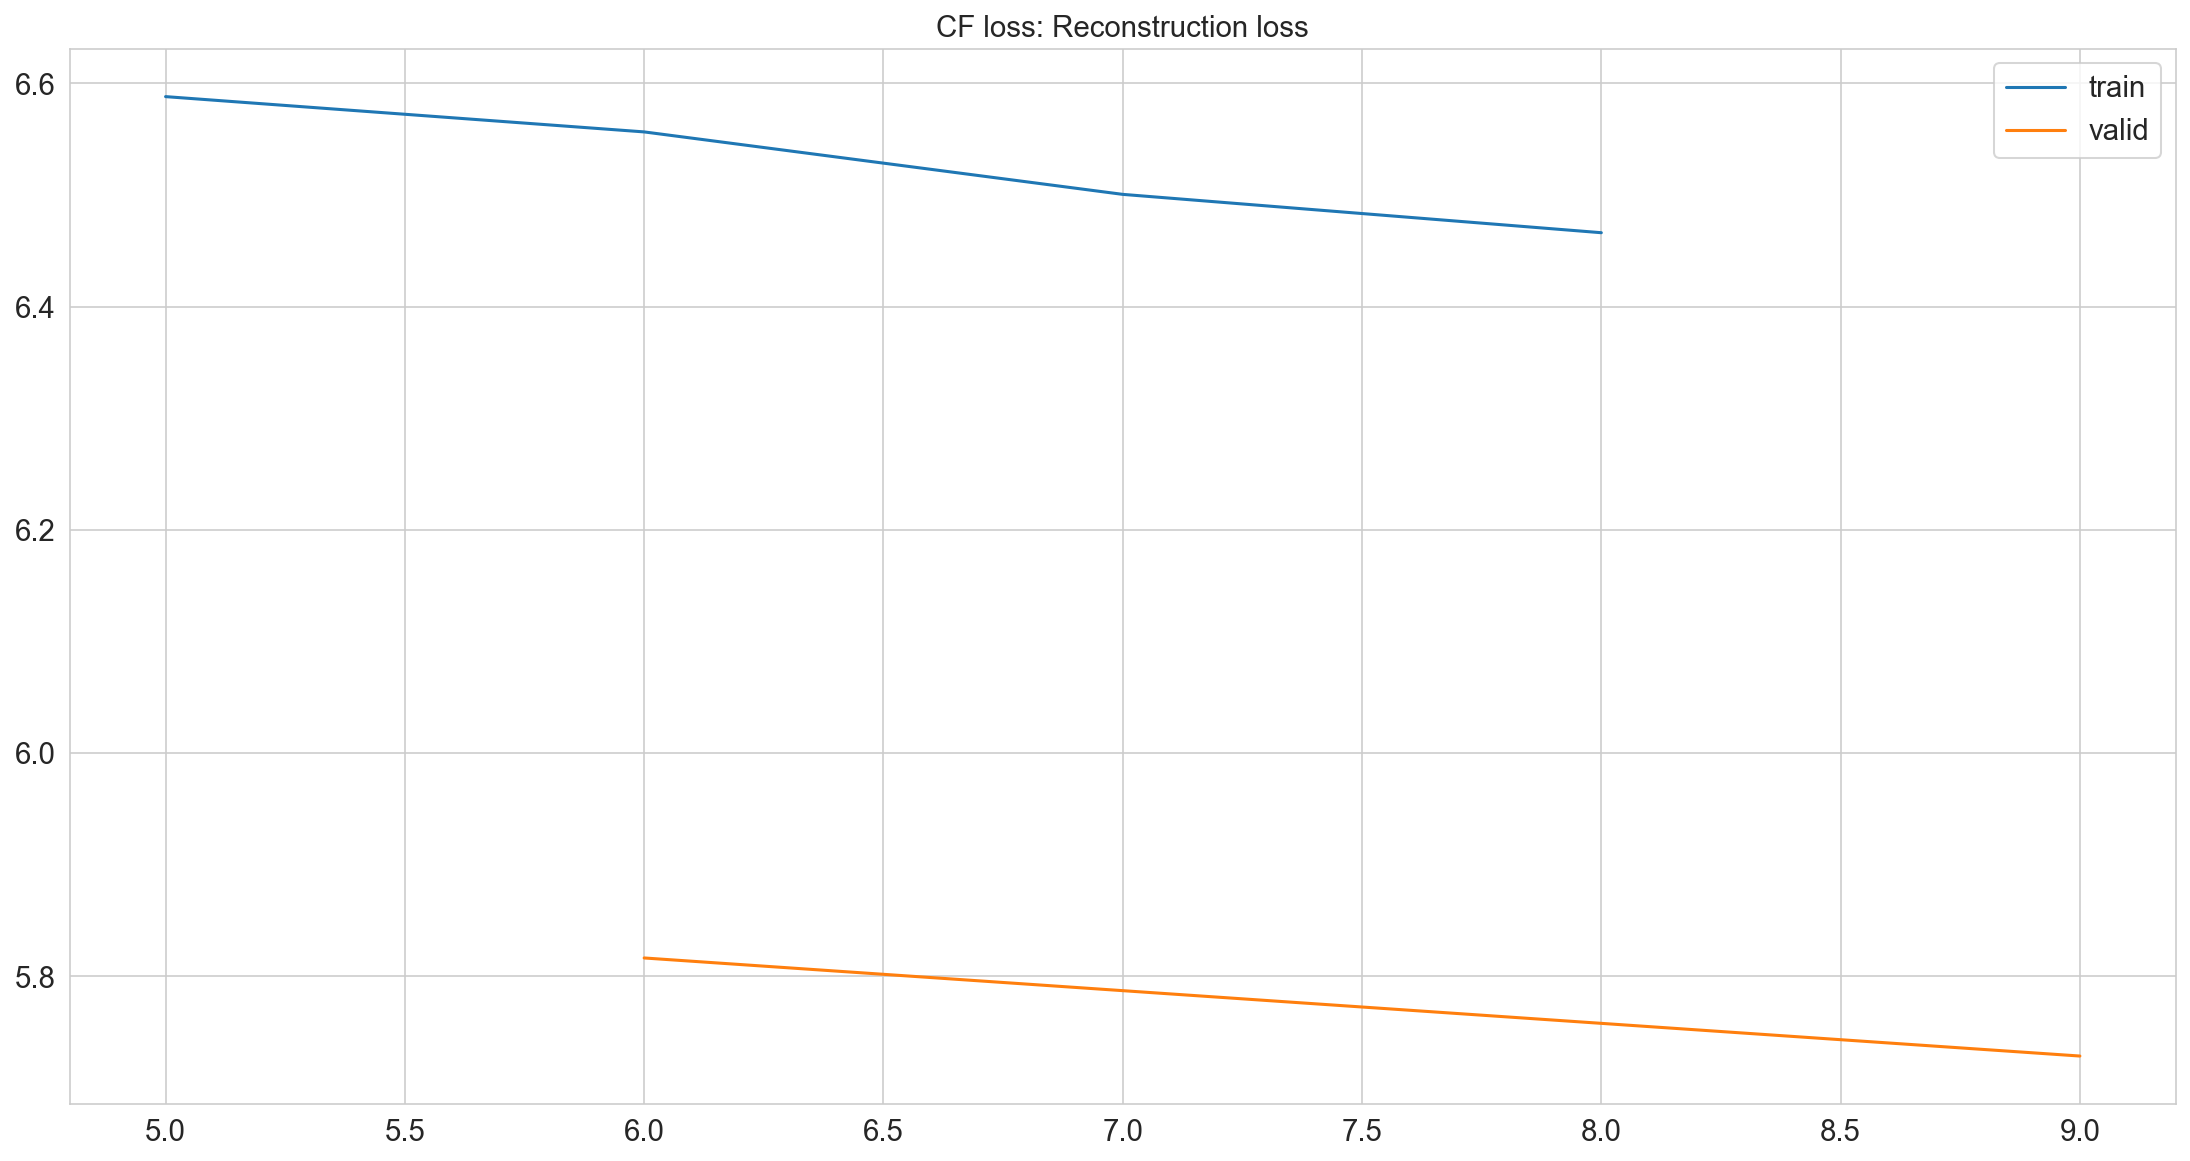

In [17]:
# papermill_description=train_collab
suggested_lr = ana_collab.learn.lr_find()
print(f"{suggested_lr.valley = :.5f}")
ana_collab.learn.fit_one_cycle(args.epochs_max, lr_max=suggested_lr.valley)
args.epoch_trained = ana_collab.learn.epoch + 1
# ana_collab.learn.fit_one_cycle(args.epochs_max, lr_max=1e-3)
ana_collab.model_kwargs['suggested_inital_lr'] = suggested_lr.valley
ana_collab.learn.save('collab_model')
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('CF loss: Reconstruction loss')
ana_collab.learn.recorder.plot_loss(skip_start=5, ax=ax)
recorder_dump = RecorderDump(
    recorder=ana_collab.learn.recorder, name='CF')
recorder_dump.save(args.out_figures)
del recorder_dump
vaep.savefig(fig, name='collab_training',
             folder=args.out_figures)
ana_collab.model_kwargs['batch_size'] = ana_collab.batch_size
vaep.io.dump_json(ana_collab.model_kwargs, args.out_models /
                  TEMPLATE_MODEL_PARAMS.format('CF'))

### Predictions

Compare simulated_na data predictions to original values

In [18]:
# this could be done using the validation data laoder now
ana_collab.test_dl = ana_collab.dls.test_dl(
    data.val_y.reset_index())  # test_dl is here validation data
val_pred_simulated_na['CF'], _ = ana_collab.learn.get_preds(
    dl=ana_collab.test_dl)
val_pred_simulated_na

,,observed,CF
Sample ID,Gene Names,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946,28.577
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248,28.408
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310,28.493
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352,28.344
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250,28.408
...,...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294,28.389
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471,28.530
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470,28.461


select test data predictions

In [19]:
ana_collab.test_dl = ana_collab.dls.test_dl(data.test_y.reset_index())
test_pred_simulated_na['CF'], _ = ana_collab.learn.get_preds(dl=ana_collab.test_dl)
test_pred_simulated_na

observed     CF
Sample ID                                      Gene Names                 
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ARAF          23.248 28.340
                                               CENPH         25.045 28.358
                                               CLPP          27.745 28.407
                                               GNAI1         24.335 28.365
                                               KIAA1143      26.901 28.425
...                                                             ...    ...
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 NUDT9         27.658 28.579
                                               PTPN1         29.024 28.618
                                               RDH13         28.720 28.540
                                               RNASEH2C      26.742 28.555
                                               SH3BGRL3      29.162 28.737

[859 rows x 2 columns]

In [20]:
if args.save_pred_real_na:
    pred_real_na = models.collab.get_missing_values(
        df_train_long=data.train_X,
        val_idx=data.val_y.index,
        test_idx=data.test_y.index,
        analysis_collab=ana_collab)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

## Data in wide format

- Autoencoder need data in wide format

In [21]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ACTR3,ADAM10,AHSA1,AK3,...,WBSCR16,WDR18,WDR33,WDR36,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,27.248,24.472,25.714,28.542,29.335,30.837,29.713,26.702,31.696,26.337,...,26.360,28.258,25.507,30.009,28.345,27.701,32.374,24.925,29.609,28.756
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.211,23.775,NaN,28.437,29.692,30.635,30.340,25.929,31.296,25.415,...,NaN,NaN,23.620,29.348,28.728,NaN,NaN,NaN,29.027,28.393
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,27.377,26.852,26.046,28.907,30.369,31.252,30.715,26.403,NaN,25.554,...,27.147,28.335,NaN,30.563,28.859,28.405,32.328,25.498,30.170,29.208
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,24.047,24.788,27.894,29.359,29.996,29.686,NaN,30.882,22.498,...,NaN,28.228,NaN,29.497,27.716,27.349,31.794,24.701,29.232,28.139
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,26.520,NaN,NaN,NaN,30.164,33.143,30.985,25.824,31.145,29.210,...,NaN,NaN,26.818,29.374,29.407,28.900,32.443,NaN,30.615,29.189


### Validation data

- all measured (identified, observed) peptides in validation data

> Does not make to much sense to compare collab and AEs,
> as the setup differs of training and validation data differs

In [22]:
# papermill_description=metrics
d_metrics = models.Metrics()

The simulated NA for the validation step are real test data (not used for training nor early stopping)

In [23]:
added_metrics = d_metrics.add_metrics(val_pred_simulated_na, 'valid_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'CF': {'MSE': 5.72873362862108,
  'MAE': 1.9245968625321523,
  'N': 859,
  'prop': 1.0}}

### Test Datasplit

Simulated NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

In [24]:
added_metrics = d_metrics.add_metrics(test_pred_simulated_na, 'test_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'CF': {'MSE': 6.107743219853425,
  'MAE': 2.005634316102109,
  'N': 859,
  'prop': 1.0}}

Save all metrics as json

In [25]:
vaep.io.dump_json(d_metrics.metrics, args.out_metrics /
                  f'metrics_{args.model_key}.json')

In [26]:
metrics_df = models.get_df_from_nested_dict(
    d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset             valid_simulated_na  test_simulated_na
model metric_name                                       
CF    MSE                       5.729              6.108
      MAE                       1.925              2.006
      N                       859.000            859.000
      prop                      1.000              1.000

## Save predictions

In [27]:
# save simulated missing values for both splits
val_pred_simulated_na.to_csv(args.out_preds / f"pred_val_{args.model_key}.csv")
test_pred_simulated_na.to_csv(args.out_preds / f"pred_test_{args.model_key}.csv")

## Config

In [28]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 376,
 'batch_size': 4096,
 'cuda': False,
 'data': Path('runs/example/data'),
 'epoch_trained': 3,
 'epochs_max': 3,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/example'),
 'latent_dim': 50,
 'model': 'CF',
 'model_key': 'CF',
 'n_params': 21828,
 'out_figures': Path('runs/example/figures'),
 'out_folder': Path('runs/example'),
 'out_metrics': Path('runs/example'),
 'out_models': Path('runs/example'),
 'out_preds': Path('runs/example/preds'),
 'patience': 1,
 'sample_idx_position': 0,
 'save_pred_real_na': True}